# *Importing Dependences*

In [34]:
# ====== Core Libraries ======
import os
import random
import warnings
import numpy as np
import pandas as pd

# ====== Visualization ======
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')

# ====== Image Processing ======
import cv2

# ====== Machine Learning Utilities ======
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ====== TensorFlow / Keras ======
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation,
    BatchNormalization
)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

# ====== Suppress Warnings ======
warnings.filterwarnings('ignore')


# *Loading Dataset*

In [35]:
# Define the path to the dataset
dataset_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

def build_dataframe(root_dir):
    image_paths = []
    image_labels = []

    # Traverse each class directory
    for label_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label_name)

        # Ensure it's a directory
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                image_paths.append(file_path)
                image_labels.append(label_name)

    # Create and return the DataFrame
    return pd.DataFrame({
        'Filepaths': image_paths,
        'Labels': image_labels
    })

# Create the DataFrame
df = build_dataframe(dataset_path)


# *Train-Test-Split*

In [36]:
# Split into training (80%) and remaining (20%)
train_df, remaining_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42
)

# Split the remaining 20% into validation (10%) and test (10%)
valid_df, test_df = train_test_split(
    remaining_df, 
    test_size=0.5,
    shuffle=True, 
    random_state=42
)

# *Data Augmentation Process*

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size as constants
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
SEED = 42

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test: only rescaling
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Helper function to create generators
def create_generator(datagen, dataframe, shuffle, name):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='Filepaths',
        y_col='Labels',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )

# Create generators
train_generator = create_generator(train_datagen, train_df, shuffle=True, name="Train")
valid_generator = create_generator(val_test_datagen, valid_df, shuffle=False, name="Validation")
test_generator  = create_generator(val_test_datagen, test_df,  shuffle=False, name="Test")

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# *Checking the distribution*

In [38]:
# Function to print dataset info
def print_split_info(name, dataframe):
    print(f"\n{name} Set:")
    print(f"Total samples: {len(dataframe)}")
    print("Samples per class:")
    print(dataframe['Labels'].value_counts())

# Count for each split
print_split_info("Training", train_df)
print_split_info("Validation", valid_df)
print_split_info("Test", test_df)


Training Set:
Total samples: 69600
Samples per class:
Labels
L          2432
S          2432
G          2431
V          2429
R          2426
J          2421
W          2420
del        2420
nothing    2416
N          2416
F          2415
O          2414
H          2413
Y          2413
B          2411
D          2404
U          2402
E          2401
I          2398
A          2397
X          2391
M          2390
space      2383
P          2381
Q          2374
K          2359
T          2351
C          2340
Z          2320
Name: count, dtype: int64

Validation Set:
Total samples: 8700
Samples per class:
Labels
B          325
C          323
I          319
T          318
W          316
X          312
K          311
Z          309
nothing    306
space      304
P          304
N          302
O          302
del        299
M          299
S          298
H          297
Q          295
E          295
L          293
A          293
F          293
U          292
D          292
Y          290
V         

# *Random ASL Alphabet Training Samples*

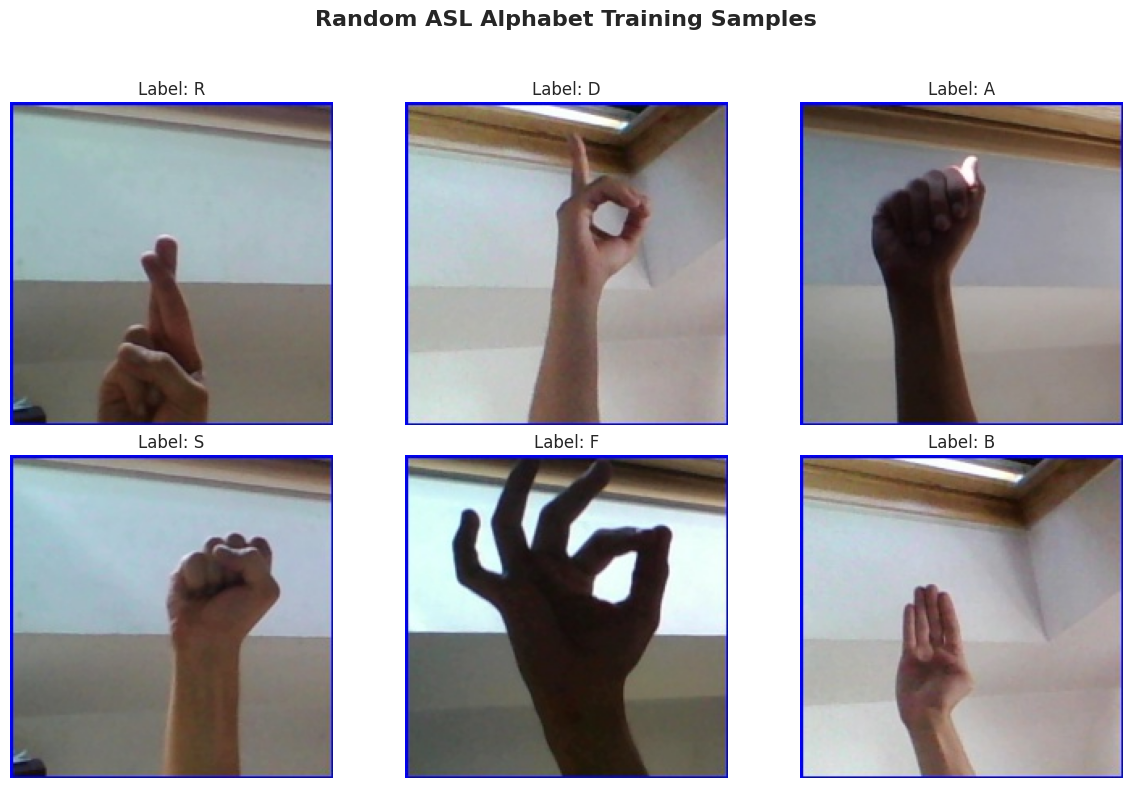

In [39]:
def plot_samples(dataframe, num_samples=6, title="Random Sample Images"):
    # Limit number of samples to the number of images available
    num_samples = min(num_samples, len(dataframe))
    
    # Randomly sample without replacement
    samples = dataframe.sample(n=num_samples).reset_index(drop=True)
    
    # Determine subplot grid layout
    cols = 3
    rows = (num_samples + cols - 1) // cols
    
    plt.figure(figsize=(cols * 4, rows * 4))
    plt.suptitle(title, fontsize=16, weight='bold')

    for i in range(num_samples):
        img_path = samples.loc[i, 'Filepaths']
        label = samples.loc[i, 'Labels']
        
        img = mpimg.imread(img_path)
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage: plot 6 random images from training set
plot_samples(train_df, num_samples=6, title="Random ASL Alphabet Training Samples")


# *Checking for class distribution in persentage*

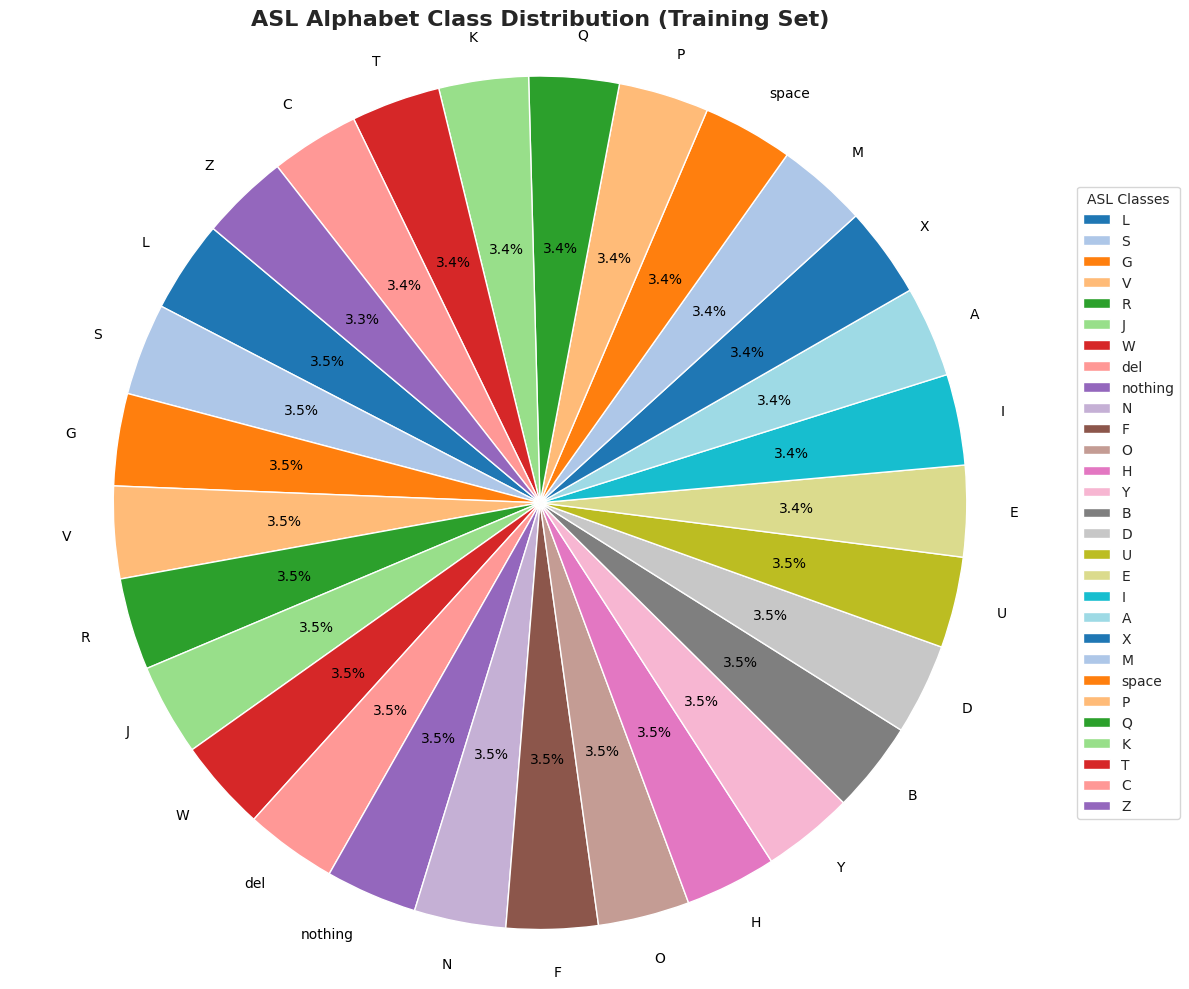

In [40]:
import matplotlib.cm as cm

# Prepare class distribution data
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']
total_images = len(train_df)
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100
class_counts = class_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Define colors using colormap
colors = cm.tab20.colors

# Plot pie chart
plt.figure(figsize=(12, 10))
wedges, texts, autotexts = plt.pie(
    class_counts['Percentage'],
    labels=class_counts['Class'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10, 'color': 'black'},
    wedgeprops={'edgecolor': 'w'}
)

# Improve legend for better clarity
plt.legend(wedges, class_counts['Class'], title="ASL Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('ASL Alphabet Class Distribution (Training Set)', fontsize=16, fontweight='bold')
plt.axis('equal') 
plt.tight_layout()
plt.show()

# *Pre-trained model initialization*

In [41]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='max'
)

# base_model.trainable = False

# Building Model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # As there have total 29 classes
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

# *Model Training*

In [42]:
# Train the model and save training history
history = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1,
    shuffle=False
)

Epoch 1/5


W0000 00:00:1744093223.641727     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7951 - loss: 0.8011

W0000 00:00:1744093706.640238     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7952 - loss: 0.8006

W0000 00:00:1744093710.217254     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 547s 469ms/step - accuracy: 0.7953 - loss: 0.8002 - val_accuracy: 0.9816 - val_loss: 0.1080
Epoch 2/5


W0000 00:00:1744093733.557534     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 499s 458ms/step - accuracy: 0.9794 - loss: 0.0810 - val_accuracy: 0.9938 - val_loss: 0.0357
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 516s 474ms/step - accuracy: 0.9842 - loss: 0.0630 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 507s 466ms/step - accuracy: 0.9902 - loss: 0.0385 - val_accuracy: 0.9990 - val_loss: 0.0026
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 532s 488ms/step - accuracy: 0.9905 - loss: 0.0380 - val_accuracy: 0.9995 - val_loss: 8.5168e-04


# *Test Accuracy*

In [43]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.9999 - loss: 6.3986e-04
Test Accuracy: 0.9997701048851013


# *Result Visulization*

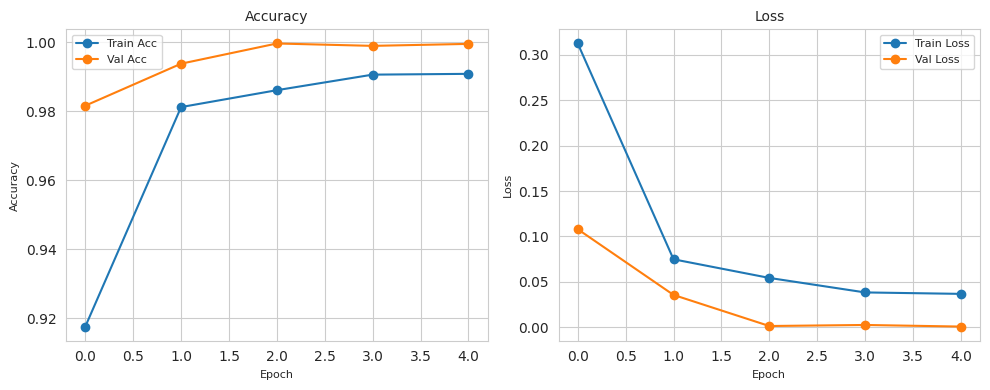

In [44]:
plt.figure(figsize=(10, 4)) 

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss', fontsize=10)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/accuracy_loss_plot.png')
plt.show()

# *Confusion Matrix*

  2/136 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step

W0000 00:00:1744095814.082056     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step


W0000 00:00:1744095831.181454     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


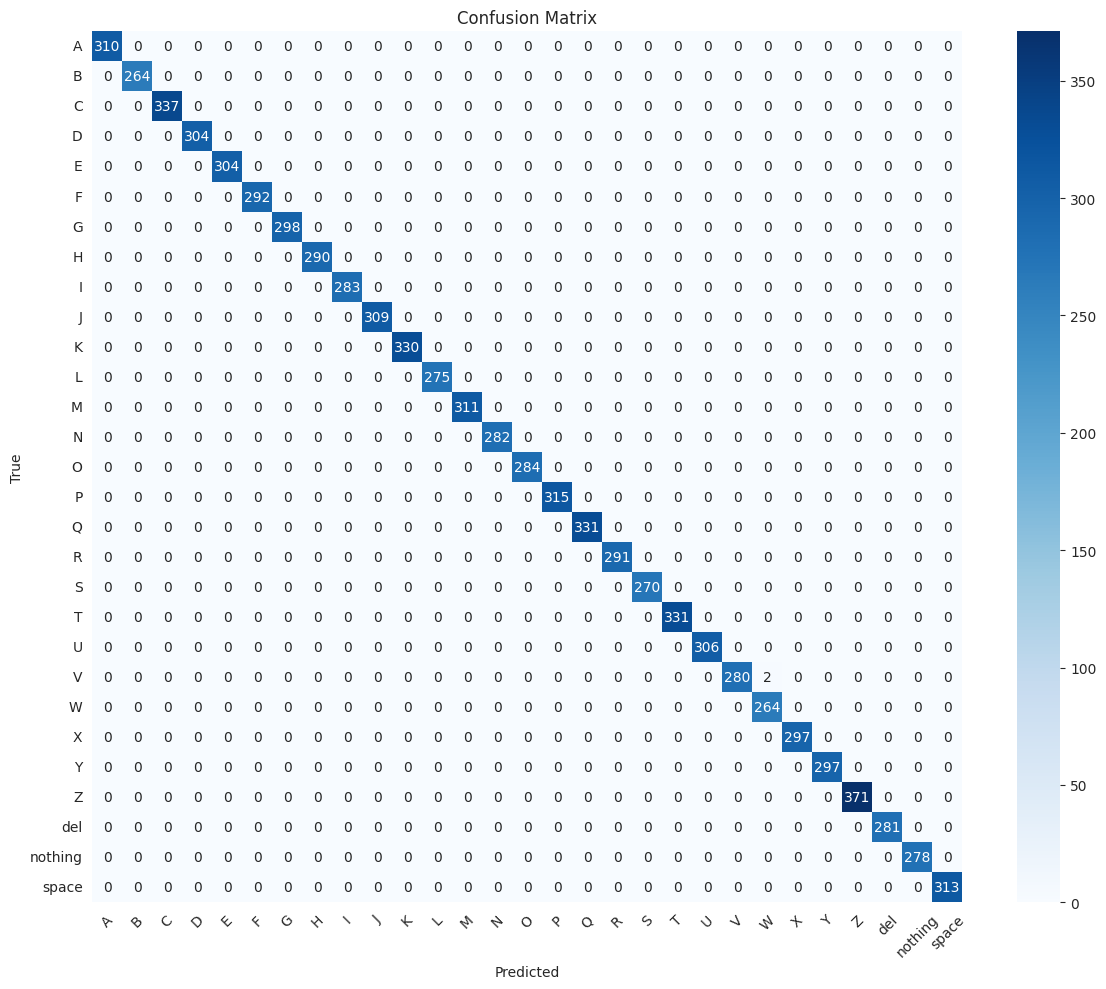

In [45]:
# Confusion Matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# *Classification Report*

In [46]:
from sklearn.metrics import classification_report

test_generator.reset()

# Get predictions and true labels
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices
true_classes = test_generator.classes  # True class indices
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=False)

# Print the report
print("Classification Report:\n")
print(report)

# Just saing the report as txt format
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)

136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step
Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       310
           B       1.00      1.00      1.00       264
           C       1.00      1.00      1.00       337
           D       1.00      1.00      1.00       304
           E       1.00      1.00      1.00       304
           F       1.00      1.00      1.00       292
           G       1.00      1.00      1.00       298
           H       1.00      1.00      1.00       290
           I       1.00      1.00      1.00       283
           J       1.00      1.00      1.00       309
           K       1.00      1.00      1.00       330
           L       1.00      1.00      1.00       275
           M       1.00      1.00      1.00       311
           N       1.00      1.00      1.00       282
           O       1.00      1.00      1.00       284
           P       1.00      1.00      1.00       315
           Q 

# *Predictions with 12 images*

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


W0000 00:00:1744095852.337999     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


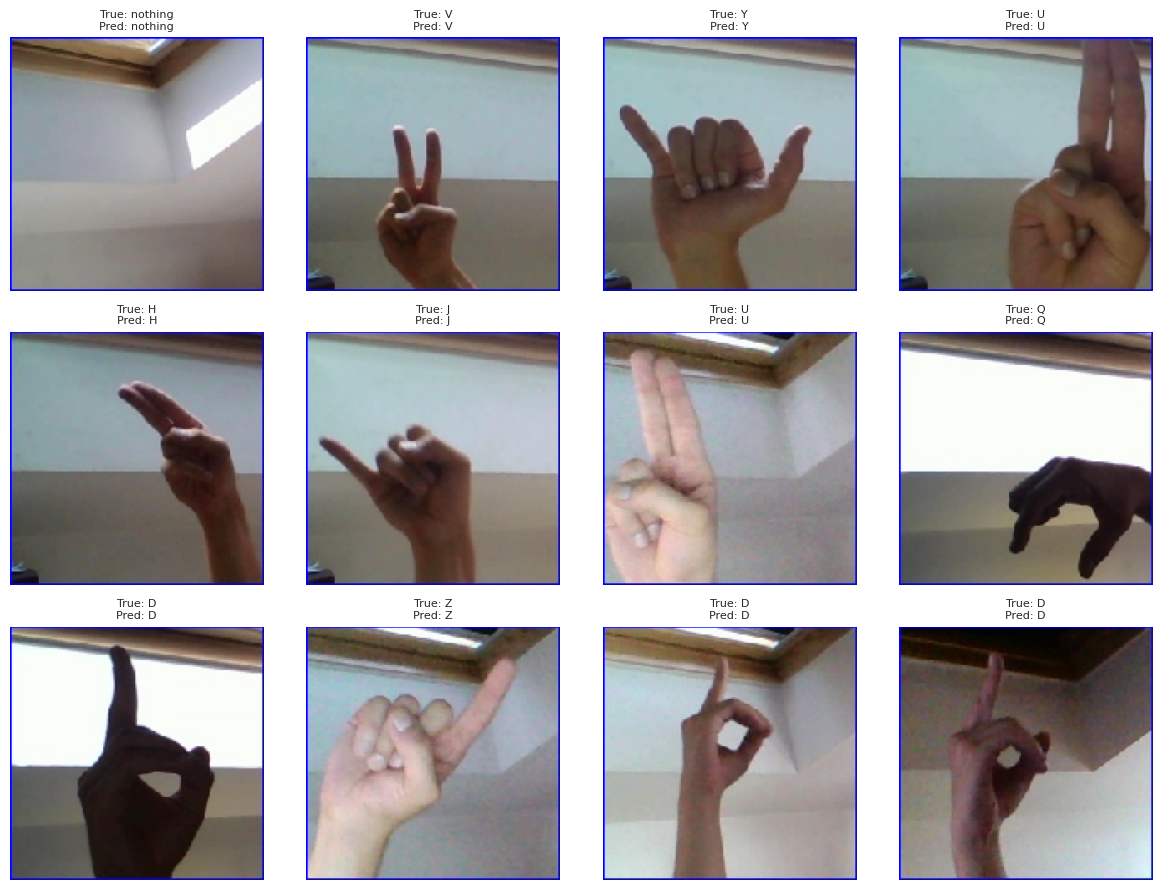

In [47]:
# Sample Predictions with 12 images
def plot_sample_predictions(generator, model, num_samples=12):
    generator.reset()
    images, labels = next(generator) 
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())
    
    plt.figure(figsize=(12, 9))
    for i in range(num_samples):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[true_labels[i]]}\nPred: {class_labels[pred_labels[i]]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions_12.png')
    plt.show()

plot_sample_predictions(test_generator, model, num_samples=12)

# *Saving the Model*

In [48]:
model.save('asl_gesture_model.keras')
print("Model saved successfully in .keras format!")

Model saved successfully in .keras format!


In [49]:
import sys
import tensorflow as tf

# Check Python version
print("Python version:", sys.version)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


Python version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
TensorFlow version: 2.15.0
